In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Generalised Linear Models
`statsmodels` is far more than a linear regression powerhouse. It is also capable of fitting a range of *generalised* linear models, that allow users to fit models to non-normal data, such as binary, count, hierarchical models, and generalised estimating equations. We will explore some of these using the in-built datasets from `statsmodels`. These are located under the **non-formula** import of the package, which exposes a far wider range of functions outside of the nice formula interface we have seen so far.

In [2]:
# Import general statsmodels
import statsmodels.api as sm # traditional alias

### Logistic Regression
We will first explore the use of logistic regression, which allows for the modelling of binary data - such as whether a trial was correct/incorrect, a participant was male/female, and so on. For this example we will use the [RAND Health Insurance Experiment data](http://www.rand.org/health/projects/hie.html) which contains a set of variables related to health insurance claims that have been used to investigate key questions in health insurance. The variables are:

- `mdvis` - Number of outpatient visits to an MD
- `lncoins` - ln(coinsurance + 1), 0 <= coninsurance <= 10
- `idp` - 1 if individual deductible plan, 0 otherwise
- `lpi` - ln(max(1, annual participation incentive payment)
- `fmde` - 0 if idp = 1; ln(max(1, MDE/(0.01 coinsurance))) otherwise
- `physlm` - 1 if the person has a physical limitation
- `disea` - number of chronic disease
- `hlthg` - 1 if self-rated health is good
- `hlthf` - 1 if self-rated health is fair
- `hlthp` - 1 if self-rated health is poor

We will attempt a simple logistic regression model, predicting whether someone has an individual deductible plan, `idp` (coded as 1 if yes, and zero if no) from a few predictors - number of chronic diseases `disea`, number of outpatient visits `mdvis`, and coinsurance, the amount that has to be paid if a claim is made, `lncoins`. 

To fit logistic regression models, we can use the `logit` function from the formula `smf` interface, and specify our model with a formula string. But first we load the data (with a slightly unusual syntax) from the non-formula interface:

In [3]:
# Load RAND data
rand = sm.datasets.randhie.load_pandas().data

# Fit the model
logistic_results = smf.logit('idp ~ disea + mdvis + lncoins', data=rand).fit()

# Examine the results
logistic_results.summary()

Optimization terminated successfully.
         Current function value: 0.537159
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    idp   No. Observations:                20190
Model:                          Logit   Df Residuals:                    20186
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Jun 2022   Pseudo R-squ.:                 0.06261
Time:                        09:14:49   Log-Likelihood:                -10845.
converged:                       True   LL-Null:                       -11570.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5700      0.034    -16.585      0.000      -0.637      -0.503
disea          0.0122      0.003      4.865      0.000       0.007       0.017
mdvis         -0.0495      0.005    -10.399      0.000      -0.059      -0.040
lncoins       -0.3259      0.009    -34.907      0.000      -0.344      -0.308
==============================================================================
"""

Success! But what does all this mean? Logistic regression isn't as easy to interpret as ordinary least squares, where a single unit increase in the predictor is associated with a coefficient-value change in the outcome. Logistic regression actually models the *probability* of a positive/yes/one response in the outcome variable, but does so using the **logistic function**, which maps probability space, which is zero to one, to an infinite continuous space of positive and negative. 

The way it does this is by converting probabilities to odds, and then taking the logarithm of the odds - the log-odds. All coefficients in logistic regression represent the change in the log-odds of the outcome with a one-unit increase of the predictor. 

Let's try to clear this up by looking at the model. The `mdvis` predictor shows a significant, negative relationship with the outcome on the log-odds scale. We have no idea what this means outside of that when the number of visits go up, the probability of having a deductible plan goes down. But if we *exponentiate* the coefficient, we undo the logarithm and get the odds back, which are somewhat more interpretable. `numpy` can help us here!

In [4]:
# Use numpy to exponentiate the coefficients
# numpy has an .exp function
# the coefficients are stored in the .params model attribute
odds = np.exp(logistic_results.params)
odds

Intercept    0.565516
disea        1.012295
mdvis        0.951673
lncoins      0.721882
dtype: float64

This is somewhat more interpretable. As the number of medical visits increases by one, the odds of having an individual deductible plan change by 0.95% (or indeed decrease by 5%). 

Unlike ordinary least squares, understanding a logistic regression model involves working closely with the predictions. We saw how to get those from an `ols` object above, but logistic regression is a different beast. While it does have a `.fittedvalues` attribute, it represents the predictions on the log-odds scale. To get at our predictions, we can do two things:

- Apply the reverse transformation using `scipy.special.expit` on the `.fittedvalues` attribute. This is the inverse-log-odds transform (sometimes known as the inverse logit) and will return the probabilities of a positive response.
- Use the `.predict` method of the fitted model to give the probabilites already back-transformed.

The latter doesn't invovle an extra import but we will show both:

In [5]:
# import scipy function
from scipy.special import expit
expit_results = expit(logistic_results.fittedvalues)

# Use prediction
logistic_predictions = logistic_results.predict() # a no-argument call predicts the data the model was fitted on

# Are these the same?
np.all(expit_results == logistic_predictions)

True

These are equivalent operations. Let's work with the `logistic_predictions` data, and add it directly to the `rand` data.

In [6]:
# add a column
rand['predictions'] = logistic_results.predict()

display(rand.head())

,mdvis,lncoins,idp,lpi,fmde,physlm,disea,hlthg,hlthf,hlthp,predictions
0,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403
1,2,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.118646
2,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403
3,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403
4,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403


Our model has given us the predictions of whether someone has an individual deductible plan. If you're not used to logistic regression it may be a surprise that you get probabilities back and not zeros and ones, which is what you have in the observed data. Its actually entirely up to *you* how you interpret those probabilities and to map them onto the observed data, but its tradition that we assume the outcome variable is a $Bernoulli$ distributed variable (stats speak for its a coin toss with 50/50 heads-tails outcomes). So, we can actually convert the probabilities into zeros and ones with a simple boolean operation:

In [7]:
# add zeros/ones
rand['predicted_idp'] = np.where(rand['predictions'] <= .50, 0, 1)

rand.head()

,mdvis,lncoins,idp,lpi,fmde,physlm,disea,hlthg,hlthf,hlthp,predictions,predicted_idp
0,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0
1,2,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.118646,0
2,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0
3,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0
4,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0


We can now examine how well the model did in terms of its predictions, by computing the terrifyingly named *confusion matrix*. All this represents is how our model did - for example, when a datapoint *did* have an individual deductible, how many times did the model say it did? What about the reverse - did it say no when it should have said no? 

Evaluating the performance of logistic regression models is an entire sub-field of statistics in and of itself. You will sometime see terms like precision, recall, accuracy, true positive rate, false positive rate, and many, many more floating around. All of these refer to - basically - is whether the model is saying 'yes' when it should and 'no' when it should, and there are many variations along that theme. Personally I find this the most confusing part of statistical practice and find myself always referring to [this diagram](https://en.wikipedia.org/wiki/Template:Diagnostic_testing_diagram) when working here - I am sure you will too!

Let's use the `pd.crosstab` function to build the confusion matrix, which takes two columns of 1/0 responses and counts the values:

In [8]:
# Crosstabs can be normalised or not, depending on the use of the `normalize` keyword
confused1 = pd.crosstab(rand['idp'], rand['predicted_idp'], margins=True, normalize=False)
confused2 = pd.crosstab(rand['idp'], rand['predicted_idp'], margins=True, normalize=True)
display(confused1, confused2)

predicted_idp,0,1,All
idp,,,
0,14939,2,14941
1,5249,0,5249
All,20188,2,20190


predicted_idp,0,1,All
idp,,,
0,0.739921,0.000099,0.74002
1,0.259980,0.000000,0.25998
All,0.999901,0.000099,1.00000


What this hopefully highlights is that, despite obtaining significant coefficients, the predictions of the model here were pretty poor - in fact, our model barely made a positive prediction! Only 2 cases (both wrong, ironically) were predicted as positive. This would be a good time to revise the model and include extra predictors. 

Classification is a surprisingly difficult area of statistics - be sure to look beyond model fit and p-values. 

### Poisson or Negative Binomial models

Though not encountered too often in psychological science, data that are distributed as counts are popular across other fields and are becoming more popular in research. Count data represent data that are coded as whole numbers (integers) that start at zero and have no upper limit. Normal regression models like ordinary least squares may make negative count predictions, or fractional predictions, which make little sense (what does it mean to have, say, negative counts of a behaviour, or 2.31201 instance of a behaviour?).

Fortunately, count data can be modelled relatively simply with either a $Poisson$ or $Negative Binomial$ regression. These models are named after the distributions of the same name which describe the probability of count data. The Poisson is a straightforward single-parameter distribution that describes distributions of counts. The single parameter is sometimes called the 'rate', and it represents the average of all the count data in a Poisson distribution. So while the Poisson distribution produces whole-integer values, its parameter can be a continuous (positive!) value. 

The negative binomial is traditionally used to describe the probability of observing a number of failures before a single success - e.g. how many times must I roll a dice *before* I get a 3? The number of 'fails' (roll != 3) would be modelled by the negative binomial. 

Sometimes, the single-parameter Poisson does a good enough job in regression contexts. However sometimes we encounter a phenomenon called *over-dispersion*, which is where the variability of the counts exceeds the average tendency. Fortunately, the negative binomial can be used instead, as it allows for a second parameter to incorporate the variability. 

If this sounds too technical, don't worry - it really is. The details are not vital; what we need to focus on is if we are dealing with count data, we can start with the Poisson model, check for this overdispersion, and if it appears, switch to the negative binomial.

#### Poisson Regression

Using the `rand` data, we could think of a different research question, asking whether the number of medical visits `mdvis` (a count variable!) is influenced by the coinsurance payment `lncoins`, as well as the number of chronic diseases, `disea`. Doing this in `statsmodels` is very easy - same idea as before; get the formula ready and use the `Poisson` function!

In [9]:
# Fit a Poisson regression
poisson_results = smf.poisson('mdvis ~ lncoins + disea', data=rand).fit()

# Summarise
poisson_results.summary()

Optimization terminated successfully.
         Current function value: 3.141408
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                  mdvis   No. Observations:                20190
Model:                        Poisson   Df Residuals:                    20187
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Jun 2022   Pseudo R-squ.:                 0.04835
Time:                        09:14:49   Log-Likelihood:                -63425.
converged:                       True   LL-Null:                       -66647.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6474      0.009     75.120      0.000       0.630       0.664
lncoins       -0.0597      0.002    -27.788      0.000      -0.064      -0.055
disea          0.0409      0.001     81.383      0.000       0.040       0.042
==============================================================================
"""

Great, some results! What do these mean again? 

Like logistic regression, Poisson regression uses a special kind of function to transform the outcome variable in order to model it. It uses a log-transform, which means the coefficients are on the log-scale. That is, as the predictor increases, the log-count of the variable increases by one. As before we can exponentiate these:

In [10]:
# Exponentiate
display(np.exp(poisson_results.params))

Intercept    1.910517
lncoins      0.942055
disea        1.041777
dtype: float64

That is somewhat clearer - as the number of diseases increases, so does the count of doctors visits. And, as the premium goes up, the number of visits go down. This makes sense, the pricier it is to get healthcare, the less likely you are to go. 

As with other kinds of generalized linear models, its often easier to work with the predictions directly to draw some conclusions. If we call the `.predict` method on fitted Poisson regression model, we will get the predictions back with no transformations needed. If you want to verify its correct you can exponentiate the `.fittedvalues` attribute and you will get the same results!

In [11]:
# Call predict and store the predictions in the rand dataframe
rand['predicted_mdvis'] = poisson_results.predict()

display(rand.head())

,mdvis,lncoins,idp,lpi,fmde,physlm,disea,hlthg,hlthf,hlthp,predictions,predicted_idp,predicted_mdvis
0,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425
1,2,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.118646,0,2.544425
2,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425
3,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425
4,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425


Something unusual is going on. The predicted values are floating numbers, *not* count data. Whats happening here? Much like with ordinary least squares and logistic regression, Poisson regression is predicting the *expected* value of the observed data point - essentially, what the average value of that data point would be, given its values on the predictors. So what we are really looking at here is the parameter or 'rate' of the distribution that the data point came from!

We can expand our fishing adventures by using an alternative function in the results object of a Poisson regression, `.predict_prob`. This function takes the predicted rate (our `predicted_mdvis` variable above, and it does something quite clever:

- It takes all the whole numbers from zero the maximum count value observed in the data.
- For each datapoint, it takes the predicted rate, and builds a *probability mass function* from a Poisson distribution with *that* rate. What's a probability mass function?! Its just the probability of seeing a specific count value, given a particular Poisson 'rate'. 
- It returns all of those probabilities to us, and we can see what has the highest value - the most probable count value of our data.

This is going to be a little tricky to unpack, so lets do this step by step in the order above.

In [12]:
# Build a set of values from zero to the maximum observed in our data
# We add one because of Pythons 'up to but don't include' rule - see chapter 1!
counts = np.arange(0, max(rand['mdvis'] + 1))

# Get the probability mass of each datapoint, given the predicted rate!
probability_mass = poisson_results.predict_prob()

# Put these in a dataframe
prob_mass_df = pd.DataFrame(probability_mass, columns=counts)
display(prob_mass_df.head(2))

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.078518,0.199784,0.254167,0.21557,0.137125,0.069781,0.029592,0.010756,0.003421,0.000967,...,1.203950e-70,4.439651e-72,1.613766e-73,5.783247e-75,2.043755e-76,7.123537e-78,2.449365e-79,8.309635e-81,2.782006e-82,9.192993e-84
1,0.078518,0.199784,0.254167,0.21557,0.137125,0.069781,0.029592,0.010756,0.003421,0.000967,...,1.203950e-70,4.439651e-72,1.613766e-73,5.783247e-75,2.043755e-76,7.123537e-78,2.449365e-79,8.309635e-81,2.782006e-82,9.192993e-84


OK! Only two datapoints are shown but we have the probability that the datapoint is the count shown in the DataFrame header, given the predicted rate. If we want to collapse this into a single number, all we need to is take index with the maximum value (i.e. , for row one, what is the column with the highest probability?)

`pandas` can help here, with the `.idxmax` method.

In [13]:
# Assign this back to the rand data
rand['predicted_count_mdvis'] = prob_mass_df.idxmax(axis='columns')

display(rand.head())

,mdvis,lncoins,idp,lpi,fmde,physlm,disea,hlthg,hlthf,hlthp,predictions,predicted_idp,predicted_mdvis,predicted_count_mdvis
0,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425,2
1,2,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.118646,0,2.544425,2
2,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425,2
3,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425,2
4,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0,0.129403,0,2.544425,2


OK, now we have predicted counts! What does that look like?

<AxesSubplot:xlabel='predicted_count_mdvis', ylabel='mdvis'>

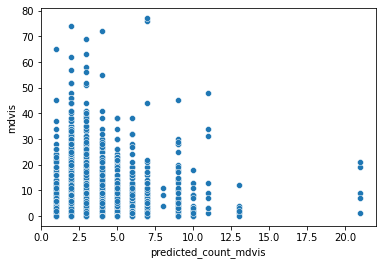

In [14]:
sns.scatterplot(y=rand['mdvis'], x=rand['predicted_count_mdvis'])

Not great, sadly. The model is really under-predicting - the observed data goes from 0 to 77, but the predictions only top 20. Is our data over-dispersed? We can check this, but it involves a little manual calculation - nothing too bad, though. First we take the models *Pearson residuals*, square them, and sum them. Then we divide this by the residual degrees of freedom of the model. If the result is greater than 1, we have evidence of overdispersion and should switch our modelling strategy.


In [15]:
# Compute overdispersion
od = (poisson_results.resid_pearson ** 2 ).sum() / poisson_results.df_resid

print(od, od > 1)

6.437470502281646 True


That might explain our not-so-good predictions.

#### Negative Binomial Regression
Fitting a negative binomial regression at this point should be intuitive - we simply set up the formula, and pass it directly to the `negativebinomial` function:

In [16]:
# Fit the model 
negbinom_results = smf.negativebinomial('mdvis ~ lncoins + disea', data=rand).fit()

# Get summary
negbinom_results.summary()

Optimization terminated successfully.
         Current function value: 2.159078
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                  mdvis   No. Observations:                20190
Model:               NegativeBinomial   Df Residuals:                    20187
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Jun 2022   Pseudo R-squ.:                 0.01374
Time:                        09:14:50   Log-Likelihood:                -43592.
converged:                       True   LL-Null:                       -44199.
Covariance Type:            nonrobust   LLR p-value:                1.480e-264
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6264      0.020     31.766      0.000       0.588       0.665
lncoins       -0.0633      0.005    -13.482      0.000      -0.072      -0.054
disea          0.0431      0.001     31.612      0.000       0.040       0.046
alpha          1.3365      0.019     70.288      0.000       1.299       1.374
==============================================================================
"""

The interpretation of the coefficients is much the same as the Poisson regression case, with the estimates representing the change in the log-counts of the outcome variable with a one-unit change in the predictor variable. Exponentiating them casts them on an odds scale. 

You may notice the model seems to have an extra estimate - `alpha` - that also has a significance test associated with it. This is the **overdispersion parameter**. Recall that the Poisson distribution has a single parameter, the 'rate', or average. If the counts vary a lot, the Poisson will find it difficult to model the variability with a single parameter. The negative binomial distribution has a similar rate or average, but also has an additional parameter, alpha, which controls the variability of the counts. The model tests whether this value is significantly different from zero, which seems to be the case here. It's another way of examining over-dispersion! Interestingly, if this parameter equals zero, the model is mathematically equivalent to a Poisson regression.